
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

# Projet A2021 : Prédire les maladies cardiaques

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/3a185493d8bb48d8961ad50e465bed4f

Ce calepin Jupyter de base permet de 

1. Charger les données fournies.
2. Effectuer une analyse exploratoire sommaire des données.
3. Développer un modèle simple de prédiction.
4. Générer le fichier de prédictions à téléverser sur Kaggle.

Dans un premier temps, vous devrez récupérer les données sous l'onglet *data* du site Kaggle. Il y a deux fichiers :
- train.csv
- test.csv

Le fichier *train.csv* contient les données sur lesquelles vous pouvez entraîner votre modèle. Il sera ensuite évaluée sur les données de l'ensemble *test.csv* lorsque vous aurez téléversé vos prédictions sur Kaggle. 

### Consignes

- Vous devez constituer une équipe de 3 à 5 personnes.
- Au moins une solution doit être proposée sur Kaggle.
- Utilisez votre numéro d'équipe pour téléverser vos prédictions sur Kaggle.
- Un seul fichier .ipynb par équipe faisant office de rapport et permettant de reproduire vos meilleures prédictions doit être remis.
- Le langage Julia doit être utilisé.
- Votre démarche doit être rigoureusement justifiée (consultez la grille de correction pour vous orienter).

### Quelques conseils

Votre calepin doit permettre de suivre clairement votre raisonnement et de reproduire vos résultats. Garder à l'esprit que vos résultats et votre démarche doivent être reproductibles par une personne à l'extérieur de votre équipe. Le calepin constitue le rapport. Servez vous des cellules de texte pour décrire ce que vous faites.

Je vous encourage fortement à faire une analyse exploratoire de vous données pour développer une meilleure expertise du problème. C'est une étape qui est toujours négligée par les débutants mais qui est essentielle. C'est avec l'analyse exploratoire que vous viendra des idées d'amélioration, par exemple créer de nouvelles variables explicatives.

Vous pouvez utiliser directement tout ce qui se retrouve dans les notes de cours sans explication et toutes les librairies utilisées dans le cours (incluant mes fonctions).

Ce calepin de base contient un modèle très simple de prédiction : on prédit 0 débordement à tous les jours. Ce sera votre travail d'améliorer ces prédictions naïves avec la méthode de votre choix.

Il faudra que vous trouviez un moyen de traiter les données manquantes. La plupart du temps, une méthode simple d'imputation (de remplacement) des données manquantes est appropriée.

Prenez la peine de tout documenter, même les essais infructueux. Ce n'est pas nécessaire de les expliquer en détails, mais c'est important de les mentionner au moins succintement dans la discussion avec une raison possible pour leur échec. De cette façon, une personne qui reprendra votre travail dans le futur ne perdra pas de temps à réessayer une méthode déjà implémentée et infructueuse.

Vous pouvez aussi indiquer dans votre rapport les raisons qui vous font croire pourquoi une méthode à moins bien performée que ce à quoi vous vous attendiez. Vous pouvez également mentionner ce que vous auriez pu tenter si vous aviez eu plus de temps ou plus de données, etc. L'idée est de guider le prochain scientifique qui prendra la relève de votre travail.

Vous êtes limités à deux soumissions par jour par équipe sur Kaggle. Je vous suggère donc de bien tester vos modèles localement et de ne téléverser que vos meilleurs candidats.

In [1]:
using CSV, DataFrames, Gadfly, GLM, Statistics, MLBase, StatsBase, StatsModels
using Distributions
using LinearAlgebra 
using Missings
import Random
using Statistics

In [2]:
include("Math.jl")

convert_categorical_params

## 1. Chargement des données

Assurez vous d'avoir télécharger les données dans le répertoire de ce calepin.

In [3]:
data = CSV.read("train.csv", DataFrame);

#### 1.1 Informations sur les données

**Age** : âge du patient (années) </br>

**Sex** : le sexe du patient (M pour homme et F pour femme) </br>

**ChestPainType** : TA: Angine de poitrine typique, ATA: Angine de poitrine atypique, NAP: Douleur autre que l'angine, ASY: Asymptomatique]

Définitions:

Asymptomatique: Aucune douleur

ANGINE: L’angine survient dans des situations où le cœur doit fournir un effort supplémentaire, mais ne parvient pas à recevoir suffisamment d’oxygène en raison du rétrécissement d’une artère coronaire par l’artériosclérose.

TA: Angine typique qui survient lors des efforts connus et reproductibles

ATA: Lorsque l'angine de poitrine atypique alors elle peut de durée prolongée et peut survenir au repos. Habituellement, **une angine instable ou atypique peut être annonciatrice d'un infractus du myocarde (crise cardiaque).**

NAP: Douleur autre que l'angine

Source: https://www.icm-mhi.org/fr/soins-et-services/maladies-cardiovasculaires/angine-de-poitrine

ASY: aucune douleur de chest

**RestingBP** : tension artérielle au repos (en mm Hg)

On a ici les tensions systoliques qui est la force exerc/e lorsque le coeur se contracte et expluse le sang.

Risque faible: 120

Risque moyen: 121-134

Risque élevé: 135+

Source: https://www.coeuretavc.ca/maladies-du-coeur/risque-et-prevention/affections-qui-sont-des-facteurs-de-risque/hypertension-arterielle

**Cholesterol** : taux de cholesterol (en mm/dl)


Le cholestérol est un lipide qui est produit naturellement par le corps, mais dont la quantité peut augmenter en fonction de notre régime alimentaire.


Source: https://www.coeuretavc.ca/maladies-du-coeur/risque-et-prevention/affections-qui-sont-des-facteurs-de-risque/taux-eleve-de-cholesterol

**FastingBS** : glycémie à jeun (1 si FastingBS > 120 mg/dl, 0 sinon)

Hyperglycémie modérée ou diabète.

Source: https://sante.journaldesfemmes.fr/fiches-anatomie-et-examens/2423998-glycemie-a-jeun-taux-normal-definition-elevee-basse-comment-baisser/

**RestingECG** : électrocardiogramme au repos (Normal : normal ; ST : anomalie ST-T détectée ; LVH : hypertrophie du ventricule gauche)


LVH: 

Hypertrophie: Accroissement de la taille du coeur avec les parois du coeur qui s'épaississent. Peut se produire lorsque le coeur subit une charge de travail élevée pendant de longues périodes de temps.
    
Ventricule gauche: épaissement du muscle de la cavité inférieure gauche du coeur

Source: https://www.coeuretavc.ca/maladies-du-coeur/problemes-de-sante/hypertrophie-du-coeur

**MaxHR** : rythme cardiaque maximum (battements par minutes)

**ExerciseAngina** : angine causée par l'exercice (Y: oui ; N: non)

**Oldpeak** : mesure sur l'électrocardiogramme (https://en.wikipedia.org/wiki/ST_depression)

**ST_Slope** : la pente sur l'électrocardiogramme (Up: croissante ; Flat : constante ; Down : décroissante)

Up: Peut etre mauvais

Flat: Bon

Down: Peut etre mauvais

## 2. Analyse exploratoire sommaire

#### 2.1 Diagrammes à moustache en fonction du diagnostic et du sexe

Nous allons faire les boxplots pour toutes les variables quantitatives. Ensuite, nous allons les séparer en catégorie homme/femme pour voir s'il y a une distribution différente, car nos recherches préalables nous montraient que les hommes et les femmes pouvaient avoir une pression normale différente par exemple.

**Observations clées**:

**RestingBP**:
 - Le restingBP ne variait pas énormément sur nos données. On peut le voir en remarquant que la médiane est presque la même pour quand on ne différencie pas hommes et femmes peu importe leur diagnostic. En différenciant selon le sexe, on remarque que la courbe des hommes ne changent presque pas en fonction de s'ils sont malades ou pas. Cependant, pour les femmes, le restingBP des femmes malades est beaucoup plus élevé que ceux qui sont en santé.

**Cholesterol**:
 - Le taux de cholesterol uniquement semble être légérement supérieur lorsque les gens sont atteints de maladies cardiaques. Quand on sépare en catégories hommes, femmes on observe que le taux de cholestérol chez les femmes semble sensiblement plus élevé quand elles sont malades que lorsqu'elles ne le sont pas. Pour les hommes on remarque une légère différence.

**MaxHR**:
  - Le max HR semble être une très bonne variable explicatrice. En effet, plus il est élevé, moins les gens semblent être atteints de maladies cardiaques. On observe autant ce phénomène chez les hommes que chez les femmes.

**OldPeak**
  - Le old Peak semble également être une excellente variable explicatrice, car il semble être beaucoup plus bas lorsque les gens sont en bonnes santé et ce autant pour les hommes que pour les femmes.
  
**Age**
  - L'age semble important, car plus les personnnes sont agées plus elles semblent être sensibles aux maladies cardiaques. On observe ce phénomène chez les hommes et les femmes.

##### 2.1.1 RestingBP

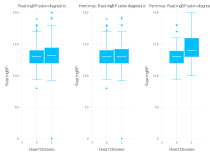

In [4]:
set_default_plot_size(21cm, 16cm)

f1 = plot(data, x=:HeartDisease, y=:RestingBP, Geom.boxplot, Coord.cartesian(xmin=-1, xmax=1.75), Guide.title("RestingBP selon diagnostic"))
hommes, femmes = groupby(data, :Sex)
f2 = plot(hommes, x=:HeartDisease, y=:RestingBP, Guide.title("Hommes: RestingBP selon diagnostic"), Geom.boxplot, Coord.cartesian(xmin=-1, xmax=1.75))
f3 = plot(femmes, x=:HeartDisease, y=:RestingBP, Guide.title("Femmes: RestingBP selon diagnostic"), Geom.boxplot, Coord.cartesian(xmin=-1, xmax=1.75))
gridstack([f1 f2 f3])

##### 2.1.3 Cholestérol

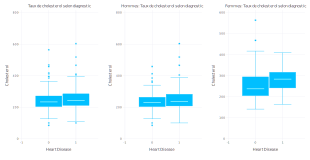

In [5]:
set_default_plot_size(31cm, 16cm)
data_no_missing = dropmissing(data)
f1 = plot(data_no_missing, x=:HeartDisease, y=:Cholesterol, Geom.boxplot, Guide.title("Taux de cholesterol selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75), Coord.cartesian(xmin=-1, xmax=1.75))
hommes_no_missing = dropmissing(hommes)
femmes_no_missing = dropmissing(femmes)
f2 = plot(hommes_no_missing, x=:HeartDisease, y=:Cholesterol, Geom.boxplot, Guide.title("Hommes: Taux de cholesterol selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75), Coord.cartesian(xmin=-1, xmax=1.75))
f3 = plot(femmes_no_missing, x=:HeartDisease, y=:Cholesterol, Geom.boxplot, Guide.title("Femmes: Taux de cholesterol selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75), Coord.cartesian(xmin=-1, xmax=1.75))
gridstack([f1 f2 f3])

##### 2.1.4 MaxHR

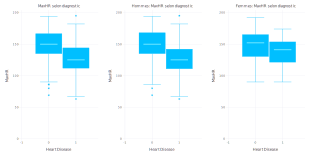

In [6]:
set_default_plot_size(31cm, 16cm)
f1 = plot(data, x=:HeartDisease, y=:MaxHR, Geom.boxplot, Guide.title("MaxHR selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f2 = plot(hommes, x=:HeartDisease, y=:MaxHR, Geom.boxplot, Guide.title("Hommes: MaxHR selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f3 = plot(femmes, x=:HeartDisease, y=:MaxHR, Geom.boxplot, Guide.title("Femmes: MaxHR selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
gridstack([f1 f2 f3])

##### 2.1.5 Age

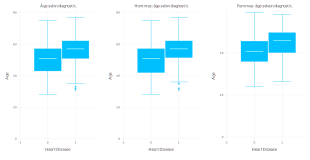

In [7]:
set_default_plot_size(31cm, 16cm)
f1 = plot(data, x=:HeartDisease, y=:Age, Geom.boxplot, Guide.title("Âge selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f2 = plot(hommes, x=:HeartDisease, y=:Age, Geom.boxplot, Guide.title("Hommes: âge selon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f3 = plot(femmes, x=:HeartDisease, y=:Age, Geom.boxplot, Guide.title("Femmes: âge seleon diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75, ymin=-1))
gridstack([f1 f2 f3])


##### 2.1.6 Oldpeak

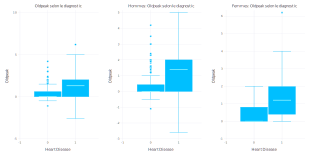

In [8]:
set_default_plot_size(31cm, 16cm)
f1 = plot(data, x=:HeartDisease, y=:Oldpeak, Geom.boxplot, Guide.title("Oldpeak selon le diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f2 = plot(hommes, x=:HeartDisease, y=:Oldpeak, Geom.boxplot, Guide.title("Hommes: Oldpeak selon le diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75))
f3 = plot(femmes, x=:HeartDisease, y=:Oldpeak, Geom.boxplot, Guide.title("Femmes: Oldpeak selon le diagnostic"), Coord.cartesian(xmin=-1, xmax=1.75, ymin=-1))
gridstack([f1 f2 f3])

#### 2.2 Diagrammes en violon des caractéristiques en fonction du diagnostic

Dans cette section, des **violin plot** sont présentés pour chacune des caractéristique et sont divisés selon le diagnostic du patient. Ces diagrammes permettent de visualiser la densité de probabilité approximative de la caractéristique. Pour cette section d'exploration, seulement les caractéristiques avec des données numériques ont été choisies.

**Age**:

- Les personnes en bas de 50 ans semblent avoir une plus petite probabilité d'avoir une maladie cardiaque
- Le mode des personnes diagnostiquées avec une maladie cardiaque semblent être autour de 55 ans
- Pouvoir prédictif semble moyen

**RestingBP**:

- Aucune diffirénce substantielle entre les personnes malades ou non selon cette caractéristique
- Pouvoir prédictif semble faible
    
**Cholesterol**:

- Distribution du choléstérol pour les personnes qui ne sont pas malades semblent être une normale centrée en 200
- Distribution du choléstérol pour les personnes qui malades a deux sommets visibles en 200 et 250
- Il semble être plus probable d'avoir un cholestérol élevé (250 et plus) si la personne est malade
- Pouvoir prédictif semble moyen
    
**MaxHR**:

- Les distributions semlbent être des inverses
- Les modes pour les personnes malades et non malades sont très différents: 125 vs 160
- Semble être probable qu'une personne ait un bas rythme cardiaque maximum si elle est malade
- Pouvoir prédictif semble fort

**Oldpeak**:

- On voit que la variance de la mesure sur l'électrocardiogramme est très faible pour les personnes non malades
- Les valeurs sont centrées autours de 0 (une pente nulle du segment ST) pour les personnes non malades
- Les malades, ont des valeurs souvent supérieures à 0 et le mode est autour de 1.25
- Possiblité de discrimer les gens non à risque avec une mesure nulle, bien qu'il y ait des execeptions
- Pouvoir prédictif semble fort


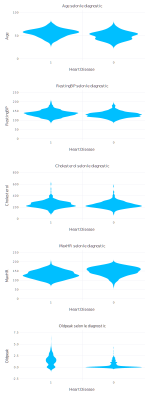

In [9]:
plots = Plot[]

# Enelver les lignes avec des données missing
full_rows_data = dropmissing(data)

# Faire le diagramme seulement pour les caractéristiques numériques
for caracteristic_name in propertynames(full_rows_data[!, [:Age, :RestingBP, :Cholesterol, :MaxHR, :Oldpeak]])
    push!(
        plots,
        plot(
            full_rows_data, 
            x=:HeartDisease,
            y=caracteristic_name,
            Geom.violin,
            Guide.title("$caracteristic_name selon le diagnostic")
        )
    )
end

Gadfly.set_default_plot_size(15cm, 40cm)
Gadfly.vstack(plots...)

#### 2.3 Histogrammes des caractéristiques en fonction du diagnostic

Pour savoir si certains paramètres suivent des distributions différentes en fonction de la variable d'intérêt (HeartDisease), nous avons généré des histogrammes pour chaque variable dans le cas des patients malades et des patients sains. Cela peut être utile pour déterminer si un mélange de loi peut être utilisé pour certaines variables ou pas.

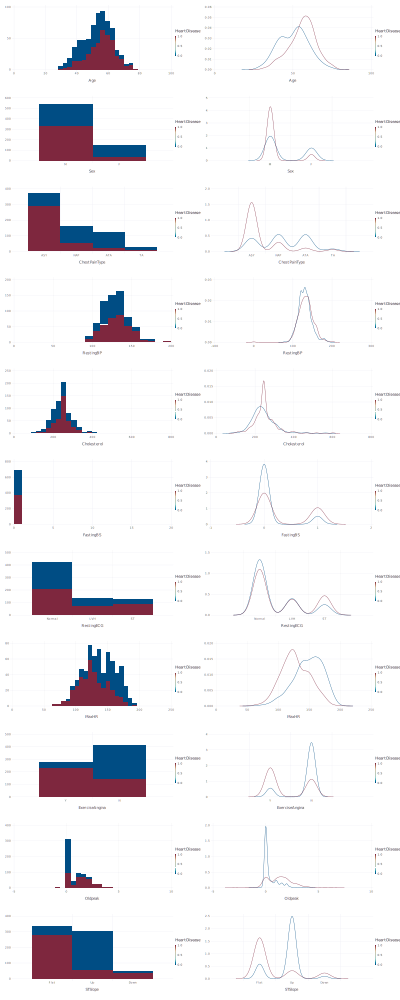

In [10]:
mean_cholesterol = mean(skipmissing(data.Cholesterol));
filled_data = coalesce.(data, mean_cholesterol);

graphs = Plot[]

for param in propertynames(data[!, Not([:ID, :HeartDisease])])
    push!(graphs, Gadfly.plot(filled_data, x=param, color=:HeartDisease, Geom.histogram(bincount=20)))
end

for param in propertynames(data[!, Not([:ID, :HeartDisease])])
    push!(graphs, Gadfly.plot(filled_data, x=param, color=:HeartDisease, Geom.density()))
end

Gadfly.set_default_plot_size(40cm, 100cm)
Gadfly.gridstack(reshape(graphs, 11, 2))

On peut remarquer à l'aide des graphiques que les fonctions de densité du STSlope et de ExerciseAngina varient en fonction du sexe. Ainsi, il serait intéressant de séparer les modèles en fonction des hommes et des femmes. Dans le cas des autres variables explicatives, les densités se ressemblent entre les deux sexes. 

#### 2.4 Analyse de la corrélation des variables

Il est important de vérifier la présence de multicolinéarité dans les données. En effet, cela peut empêcher plusieurs modèles possibles de bien performer.

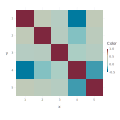

In [11]:
full_rows_data = dropmissing(data)
Gadfly.set_default_plot_size(12cm, 12cm)
spy(cor(Matrix(full_rows_data[!, [:Age, :RestingBP, :Cholesterol, :MaxHR, :Oldpeak]])))

Il ne semble pas avoir de multicolinéarité entre les différentes variables explicatives quantitatives puisqu'on remarque des carrés rouges (1) seulement selon la diagonale dans laquelle la variable est corrélée à elle même. Pour les autres paires de variables explicatives, on voit que la corrélation est proche de 0. </br> 

On peut aussi noter la présence de carrés bleus. Ces derniers indiquent une possible colinéarité entre la variable MaxHR et Age. Ainsi, les modèles qui sont affectés par la multicolinéarité (régression linéaire, régression logistique, ...) devront soit trouver une solution à la multicolinéarité ou ne pas utiliser ces deux variables ensemble lors de l'entrainement et de la prédiction.

## 3. Données manquantes, ensemble de test et de validation

Dans cette section, on remplace les données manquantes des variables aléatoires afin de pouvoir utiliser l'observation pour l'entraînement des modèles.
</br></br>
Par exemple, dans le cas du cholestérol, les valeurs manquantes vont être remplacées par la moyenne des autres valeurs. De plus, en ce qui concerne le paramètre "FastingBS", la valeur est convertie en chaîne de caractères pour que la fonction *glm()* la considère comme une variable catégorielle.
</br></br>
Il est important de noter qu'une colonne additionnelle a été ajoutée pour indiquer si la valeur du cholestérol était plus haute que 200. Ainsi, un modèle pourra ajuster sa prédiction en fonction de la présence ou non de la valeur
</br></br>
Finalement, les données ont été séparées en ensemble d'entrainement et de validation
</br></br>
De plus, nous avons noté la présence d'une donnée aberrante (RestingBP = 0, qui est impossible)

In [12]:
# Changer les missing avec la moyenne du cholestérol et ajouter une variable qui indique que la donnee est manquante
filled_data = data
cholesterol_category = zeros(0)
for elem in filled_data[!, :Cholesterol]
    append!(cholesterol_category, convert(Float64, (elem !== missing ? elem > 200 : 0)))
end
filled_data[!, :CholesterolCategory] = cholesterol_category
mean_cholesterol = mean(skipmissing(data.Cholesterol));
filled_data = coalesce.(data, mean_cholesterol);

# Convertir les variables catégorielles en String
filled_data.FastingBS = string.(filled_data.FastingBS);

# Enlever la donnee aberrante
filter!(row -> (row.RestingBP != 0), filled_data)

# Échantilloner les lignes pour l'ensemble d'entraînemenet et de validation
train_id = sample(1:nrow(filled_data), round(Int, .8*nrow(filled_data)), ordered=true);
valid_id = setdiff(1:nrow(filled_data), train_id);

# Initialiser l'ensemble d'entraînement et de validation
train = filled_data[train_id,:];
valid = filled_data[valid_id,:];


## 4. Ajustement des modèles

### 4.1 Modèle M1 (Toutes les variables explicatives)

#### 4.1.1 Construire le modèle

Le premier modèle qu'il a été possible de faire est celui contenant toutes les variables explicatives en utilisant une simple régression logistique (avec la fonction Logit).
</br>

**M1**:  HeartDisease ~ Age + Sex + ChestPainType + RestingBP + Cholesterol + FastingBS + RestingECG + MaxHR + ExerciseAngina + Oldpeak + STSlope 

In [29]:
# Construire le modèle de régression logistique
M1 = glm(@formula(
        HeartDisease ~ Age + Sex + ChestPainType + RestingBP + Cholesterol + CholesterolMissing +
        FastingBS + RestingECG + MaxHR + ExerciseAngina + Oldpeak + STSlope), 
        train, Bernoulli(), LogitLink()
)

ArgumentError: ArgumentError: There isn't a variable called 'CholesterolMissing' in your data; the nearest names appear to be: 

#### 4.1.2 Mesurer la qualité du modèle **M1**

Évaluer la qualité du modèle sur l'ensemble de **validation**

In [14]:
# Trouver les prédiction de la probabilité d'avoir une maladie sur l'échantillon de validation
θ_pred = predict(M1, valid)

# Faire les prédiction d'avoir la maladie avec un threshold de 0.5 sur la probabilité trouvée
ŷ = Int64[]
for θ̂ᵢ in θ_pred
    if θ̂ᵢ >= .5
        push!(ŷ, 1)
    else
        push!(ŷ, 0)
    end
end

UndefVarError: UndefVarError: M1 not defined

Calculer la précision de notre modèle sur l'ensemble de validation

In [15]:
println("Le taux de bonnes prédictions sur l'ensemble de validation est de ", round(correctrate(valid.HeartDisease, ŷ), digits=3),".")

UndefVarError: UndefVarError: ŷ not defined

On obtient un taux de validation assez élevé en utilisant un modèle de régression logistique basique. Cependant, il n'est pas assez élevé pour effectuer une prédiction fiable. Pour l'améliorer, nous avons décidé de jouer avec plusieurs facteurs :
- Trouver le meilleur seuil pour lequel la prédiction générée par le modèle est une maladie cardiovasculaire
- Changer les variables explicatives du modèle pour ne prendre que celles qui sont les plus significatives (Voir modèle 3)
- Considérer une régression logistique polynomiale (Voir modèle 3)


En ce qui concerne le seuil, pour le trouver, il est possible de l'approximer en observant la courbe ROC, tracée ci-dessous.

In [16]:
θ_pred = convert(Array{Float64}, θ_pred)
rocplot(valid.HeartDisease, θ_pred)

UndefVarError: UndefVarError: θ_pred not defined

Bien que la courbe ROC aide à approximer le meilleur seuil, l'approximation n'est pas assez précise. Ainsi, la méthode *find_best_threshold()* a été développée pour trouver le seuil qui apporte la meilleure prédiction sur l'ensemble de validation.

In [17]:
λ_M1 = find_best_threshold(valid, M1)

# Tester le taux de bonnes prédiction avec λ = best_threshold
# Trouver les prédiction de la probabilité d'avoir une maladie sur l'échantillon de validation
θ_pred = predict(M1, valid)

# Faire les prédiction d'avoir la maladie avec un threshold de 0.5 sur la probabilité trouvée
ŷ = Int64[]
for θ̂ᵢ in θ_pred
    if θ̂ᵢ >= λ_M1
        push!(ŷ, 1)
    else
        push!(ŷ, 0)
    end
end
println("Le taux de bonnes prédictions sur l'ensemble de validation avec λ=$λ_M1 est de ", round(correctrate(valid.HeartDisease, ŷ), digits=3),".")

UndefVarError: UndefVarError: M1 not defined

### 4.2 Modèle M2 (Séparation du modèle en fonction du sexe)

Étant donnée la grande différence de densités des variables explicatives entre les hommes et les femmes (voir l'analyse exploratoire), nous avons décidé de séparer les hommes et les femmes. En effet, le modèle 2 est en fait deux modèles à lui tout seul. Il y a une régression logistique pour les hommes et une pour les femmes (encore une fois avec toutes les variables explicatives) avec la fonction de lien Logit.

**M2_hommes** :  HeartDisease ~ Age + ChestPainType + FastingBS + ExerciseAngina + MaxHR^2 + Oldpeak^2 + STSlope
</br>
**M2_femmes** : HeartDisease ~ ChestPainType + FastingBS

Pour choisir ces paramètres, nous avons fait varier les combinaisons de paramètres en gardant ceux qui étaient les plus significatifs (Valeur P en dessous de 5%)

In [18]:
# Construire deux ensemble de test séparé par le sexe
train_hommes = filter(row -> row.Sex == "M", train);
train_femmes = filter(row -> row.Sex == "F", train);

# Construire deux ensemble de validation séparé par le sexe
valid_hommes = filter(row -> row.Sex == "M", valid);
valid_femmes = filter(row -> row.Sex == "F", valid);


M2_hommes = glm(@formula(
        HeartDisease ~ Age + ChestPainType + 
        FastingBS + ExerciseAngina + MaxHR^2 + Oldpeak^2 + STSlope), 
        train_hommes, Bernoulli(), LogitLink()
);

M2_femmes = glm(@formula(
        HeartDisease ~ ChestPainType + FastingBS), 
        train_femmes, Bernoulli(), LogitLink()
);


Évaluer la qualité du modèle sur l'ensemble **de validation**

In [19]:
# Trouver les prédiction de la probabilité d'avoir une maladie sur l'échantillon de validation
θ_pred_hommes = predict(M2_hommes, valid_hommes)
θ_pred_femmes = predict(M2_femmes, valid_femmes)


best_f = find_best_threshold(valid_femmes, M2_femmes)
best_h = find_best_threshold(valid_hommes, M2_hommes)

# Faire les prédiction d'avoir la maladie avec un threshold de 0.5 sur la probabilité trouvée
ŷ_hommes = Int64[]
for θ̂ᵢ in θ_pred_hommes
    if θ̂ᵢ >= best_h
        push!(ŷ_hommes, 1)
    else
        push!(ŷ_hommes, 0)
    end
end

ŷ_femmes = Int64[]
for θ̂ᵢ in θ_pred_femmes
    if θ̂ᵢ >= best_f
        push!(ŷ_femmes, 1)
    else
        push!(ŷ_femmes, 0)
    end
end

# rmse 

Calculer la précision de notre modèle sur l'ensemble de **validation**

In [20]:
println("Le taux de bonnes prédictions sur l'ensemble de validation des hommes avec un seuil de $best_h est de ", round(correctrate(valid_hommes.HeartDisease, ŷ_hommes), digits=3),".")
println("Le taux de bonnes prédictions sur l'ensemble de validation des femmes avec un seuil de $best_f est de ", round(correctrate(valid_femmes.HeartDisease, ŷ_femmes), digits=3),".")

Le taux de bonnes prédictions sur l'ensemble de validation des hommes avec un seuil de 0.712 est de 0.864

.
Le taux de bonnes prédictions sur l'ensemble de validation des femmes avec un seuil de 0.7 est de 0.8.


On peut observer que les prédictions sont meilleures que le modèle 1, mais après une soumission dans l'ensemble de test, le modèle 2 semble trop apprendre des données.

### 4.3 Modèle M3 (Sélection des variables explicatives les plus significatives)

Après l'analyse du modèle 1 à l'aide des intervalles de confiance des coefficients de régression, il est possible de constater que certaines variables ne sont pas significatives (leurs P-Value sont supérieures à 5%). Ainsi, la première étape fût de construire le modèle 3 en rassemblant seulement les variables explicatives qui sont significatives selon l'analyse du modèle 1.
</br></br>
Il est possible de remarquer que dans le cas de la variable explicatives *STSlope*, le coefficient de régression associé à la valeur *Flat* est significative, mais pas celui associé à la valeur *Up* (Il est important de rappeler que lorsqu'une régression logistique est effecutée avec des variables qualitatives, il y a *k* - 1 variables qui seront vraiment utilisées dans le modèle). Ainsi, le modèle n'était pas encore parfait.
</br></br>
Avec ce modèle, un assez bon score a été obtenu. Ainsi, au lieu d'enlever toutes les variables explicatives non significatives, celles qui étaient quantitatives ont été mises au carré pour tester si la régression polynomiale. C'est ainsi que les paramètres Oldpeak et MaxHR sont devenus significatives. 
</br></br>
Cependant, la significativité des paramètres dépendaient grandement de l'ensemble d'entrainement choisi (lors de la division des données en ensemble de validation et d'entrainement). C'est pourquoi nous avons décidé de faire de la validation croisée pour prendre le meilleur modèle. Pour cela, nous avons choisi de diviser les données en 5 groupes. Chaque modèle est entrainé sur 4 groupes et validé sur le dernier. À la fin, le meilleur des modèles est pris.

In [21]:
shuffled_data = filled_data[sample(1:size(filled_data,1), size(filled_data,1), replace=false),:];

best_model = undef
best_threshold = -1
best_accuracy = -1
number_of_groups = 5

for i in 1:number_of_groups
    begin_index = convert(Int, round((i - 1) * nrow(shuffled_data) / number_of_groups + 1)) 
    end_index = convert(Int, round(i * nrow(shuffled_data) / number_of_groups - 1)) + 1

    println("Validation sur l'intervalle : ", begin_index, ", ", end_index)

    valid = shuffled_data[begin_index:end_index, :]
    valid_id = valid[:, :ID]
    train_id = setdiff(1:nrow(shuffled_data), valid_id);
    train = filled_data[train_id,:]; 

    # train = shuffled_data[[[begin, begin_index], [end_index, end]], :]
    model = glm(@formula(
        HeartDisease ~ Sex + ChestPainType + CholesterolCategory + FastingBS + ExerciseAngina + MaxHR^2 + Oldpeak^2 + STSlope), 
        train, Bernoulli(), LogitLink()
    )

    threshold = find_best_threshold(valid, model)

    # Tester le taux de bonnes prédiction avec λ = best_threshold
    θ_pred = predict(model, valid)

    # Faire les prédiction d'avoir la maladie
    ŷ = Int64[]
    for θ̂ᵢ in θ_pred
        if θ̂ᵢ >= threshold
            push!(ŷ, 1)
        else
            push!(ŷ, 0)
        end
    end
    accuracy = correctrate(valid.HeartDisease, ŷ)
    println("Le taux de bonnes prédictions sur l'ensemble de validation avec avec λ=$threshold est de ", round(correctrate(valid.HeartDisease, ŷ), digits=3),".")

    if (accuracy > best_accuracy)
        best_model = model
        best_threshold = threshold
        best_accuracy = accuracy
    end
end

println()
println("==============================================================================")
println()
println(best_model)
println(best_threshold)
println(best_accuracy)


Validation sur l'intervalle : 1, 137
Le taux de bonnes prédictions sur l'ensemble de validation avec avec λ=0.359 est de 

0.883.
Validation sur l'intervalle : 138, 275


Le taux de bonnes prédictions sur l'ensemble de validation avec avec λ=0.381 est de 0.855.
Validation sur l'intervalle : 276, 412
Le taux de bonnes prédictions sur l'ensemble de validation avec avec λ=0.324 est de 0.891.
Validation sur l'intervalle : 413, 550


Le taux de bonnes prédictions sur l'ensemble de validation avec avec λ=0.666 est de 0.877.
Validation sur l'intervalle : 551, 687
Le taux de bonnes prédictions sur l'ensemble de validation avec avec λ=0.356 est de 0.898.




StatsModels

.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64

}, Bernoulli{Float64}, LogitLink}, GLM.DensePredChol{Float64, Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

HeartDisease ~ 1 + Sex + ChestPainType + CholesterolCategory + FastingBS + ExerciseAngina + :(MaxHR ^ 2) + :(Oldpeak ^ 2) + STSlope



Coefficients:


───────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error      z  Pr(>|z|)    Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────


(Intercept)          -0.760461    0.794839    -0.96    0.3387  -2.31832      0.797394
Sex: M                1.33625     0.353907     3.78    0.0002   0.64261      2.0299
ChestPainType: ATA   -1.33527     0.425837    -3.14    0.0017  -2.1699      -0.500649
ChestPainType: NAP   -1.34703     0.327292    -4.12    <1e-04  -1.98851   

  -0.70555
ChestPainType: TA    -1.20722     0.577086    -2.09    0.0364  -2.33829     -0.0761548
CholesterolCategory  -0.65748     0.293315    -2.24    0.0250  -1.23237     -0.0825925
FastingBS: 1          1.27161     0.333086     3.82    0.0001   0.618773     1.92445
ExerciseAngina: Y     1.00684     0.29949      3.36    0.0008   0.419855     1.59383
MaxHR ^ 2            -2.14969e-5  2.15981e-5  -1.00    0.3196  -6.38285e-5   2.08346e-5
Oldpeak ^ 2           0.206377    0.0566975    3.64    0.0003   0.0952523    0.317503
STSlope: Flat         1.50785     0.562846     2.68    0.0074   0.404694     2.61101
STSlope: Up          -0.925431    0.568793    -1.63    0.1037  -2.04024      0.189383
───────────────────────────────────────────────────────────────────────────────────────
0.356


0.8978102189781022


**Il est important de préciser que la précision du modèle généré dépend grandement des données choisies pour l'entrainement (certaines données aberrantes peuvent être choisies dans certains cas et pas dans d'autres par exemple).**

### 4.4 Modèle M4 (Régression Ridge)

Puis, nous avons considéré une régression Ridge pour prédire les maladies cardiovasculaires. Cependant, le grand désavantage est la grande présence de variables qualitatives dans notre jeu de données. Ainsi, il est difficile de standardiser toutes les données. Nous avons tenté de transformer les variables catégorielles en plusieurs variables indicatrices, mais sans succès face à la régression.
</br></br>
Le grand avantage de la Régression Ridge était d'empêcher la multicolinéarité des données, qui semble être présente selon l'analyse exploratoire effectuée précédemment. Ainsi, nous avons tenté de n'utiliser que les variables quantitatives pour effectuer la régression. Cependant, la précision du modèle résultant n'était pas assez précis.

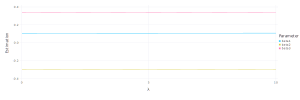

In [22]:
# Transformer les variables qualitatives en variables indicatrices
# transformed_data = convert_categorical_params(train, [:Sex, :ChestPainType, :RestingECG, :ExerciseAngina, :STSlope])

# transformed_data[!, :FastingBS] = parse.(Float64, transformed_data[!, :FastingBS])

coefnames = ["beta1", "beta2", "beta3", "beta4", "beta5", "beta6", "beta7", "beta8"]
plot_info = DataFrame(λ = Float64[], Parameter = String[], Estimation = Float64[])

transformed_data = train[:, [:Age, :MaxHR, :Oldpeak, :HeartDisease]]
dt = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(transformed_data), dims=1)
transformed_data = StatsBase.transform(dt, Matrix{Float64}(transformed_data))

# show(transformed_data)

X = Matrix{Float64}(transformed_data[:, 1:3])
Y = transformed_data[:, 4]
m = size(X, 2)

for lambda in 0.01:.01:10

    beta = (X'X + (lambda*I))\X'Y
    
    for i in 1:m
        push!(plot_info, [lambda, coefnames[i], beta[i]])
    end
    
end

Gadfly.set_default_plot_size(30cm, 10cm)
plot(plot_info, x=:λ, y=:Estimation, color=:Parameter, Geom.line)


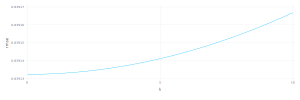

In [23]:
coefnames = ["beta1", "beta2", "beta3", "beta4", "beta5", "beta6", "beta7", "beta8"]
plot_info = DataFrame(λ = Float64[], rmse = Float64[])

dt = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(transformed_data), dims=1)
transformed_data = StatsBase.transform(dt, Matrix{Float64}(transformed_data))

X_valid = Matrix{Float64}(transformed_data[:, 1:3])
Y_valid = transformed_data[:, 4]
m = size(X, 2)

for λ in 0.01:.01:10

    β̂ = (X'X + λ*I)\X'Y
    
    ŷ = X_valid*β̂
    
    rmse = StatsBase.rmsd(ŷ, Y_valid)
    
    push!(plot_info, [λ, rmse])
    
end

plot(plot_info, x=:λ, y=:rmse, Geom.line)

In [24]:
λ̂ = plot_info.λ[argmin(plot_info.rmse)]

0.01

La régression Ridge ne semble indiquer qu'il n'y a pas de multicolinéarité, car le lambda qui minimise le MSE est le plus petit lambda possible (0.01 dans ce cas). Ainsi, on peut écarter la régression Ridge de nos possibilité



## 5. Prédiction du diagnostic pour les patients de l'ensemble de test

Finalement, pour la prédiction finale, nous avons décidé de choisir le modèle M3, car il est le plus simple et c'est celui qui a eu le meilleur score de prédiction dans l'ensemble de validation. C'est aussi celui qui a permis d'obtenir le meilleur résultat en ce qui concerne le concours Kaggle.

#### 5.1 Chargement des données de l'ensemble de test


In [25]:
test = CSV.read("test.csv", DataFrame);

# Changer les missing avec la moyenne du cholestérol
cholesterol_category = zeros(0)
for elem in test[!, :Cholesterol]
    append!(cholesterol_category, convert(Float64, (elem !== missing ? elem > 200 : 0)))
end
test[!, :CholesterolCategory] = cholesterol_category
mean_cholesterol = mean(skipmissing(test.Cholesterol));
test = coalesce.(test, mean_cholesterol);

# Convertir les variables catégorielles en String
test.FastingBS = string.(test.FastingBS);

#### 5.2 Prédiction pour chacun des patients de l'ensemble de test

In [26]:
# Choisir le modele choisi
M_choisi = best_model
threshold_choisi = best_threshold

θ_pred_remise = predict(M_choisi, test)

ŷ = Int64[]

for θ̂ᵢ in θ_pred_remise
    if θ̂ᵢ >= threshold_choisi
        push!(ŷ, 1)
    else
        push!(ŷ, 0)
    end
end

#### 5.3 Préparation du fichier des préditions pour téléverser sur Kaggle

Le fichier *benchmark_predictions.csv* généré peut être téléversé sur Kaggle. Il est composé d'une colonne d'identifiants (ID) et d'une colonne des diagnostics prédits.

In [27]:
prediction = DataFrame(ID = test.ID, Prediction = ŷ)

CSV.write("benchmark_predictions.csv", prediction)

"benchmark_predictions.csv"